In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re
summarized = 0
feature_subset = 3
vectorize_text = 1

In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
# download nltk everythin
nltk.download('all')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averag

True

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in tagged_tokens])

In [ ]:
suhi_df = pd.read_excel('/content/Fewshot_new_final_summary.xlsx')

In [ ]:
# drop null value in notes
suhi_df.dropna(subset=['COMBINED_NOTES'], inplace=True)

In [ ]:
# count of each word appeared in the entire series/column
combined_notes_word_count = {}
llm_summary_notes_word_count = {}
for index, row in suhi_df.iterrows():
    # lowercase
    row['COMBINED_NOTES'] = row['COMBINED_NOTES'].lower()
    row['FEW_SHORT_LLM_SUMMARY'] = row['FEW_SHORT_LLM_SUMMARY'].lower()
    combined_notes = row['COMBINED_NOTES']
    llm_summary = row['FEW_SHORT_LLM_SUMMARY']
    if pd.notna(combined_notes):
        for word in combined_notes.split():
            if word in combined_notes_word_count:
                combined_notes_word_count[word] += 1
            else:
                combined_notes_word_count[word] = 1
    if pd.notna(llm_summary):
        for word in llm_summary.split():
            if word in llm_summary_notes_word_count:
                llm_summary_notes_word_count[word] += 1
            else:
                llm_summary_notes_word_count[word] = 1

In [ ]:
# Give me bar charts with top 10  word from both dictionaries
combined_notes_word_count_df = pd.DataFrame(list(combined_notes_word_count.items()), columns=['word', 'count'])
llm_summary_notes_word_count_df = pd.DataFrame(list(llm_summary_notes_word_count.items()), columns=['word', 'count'])

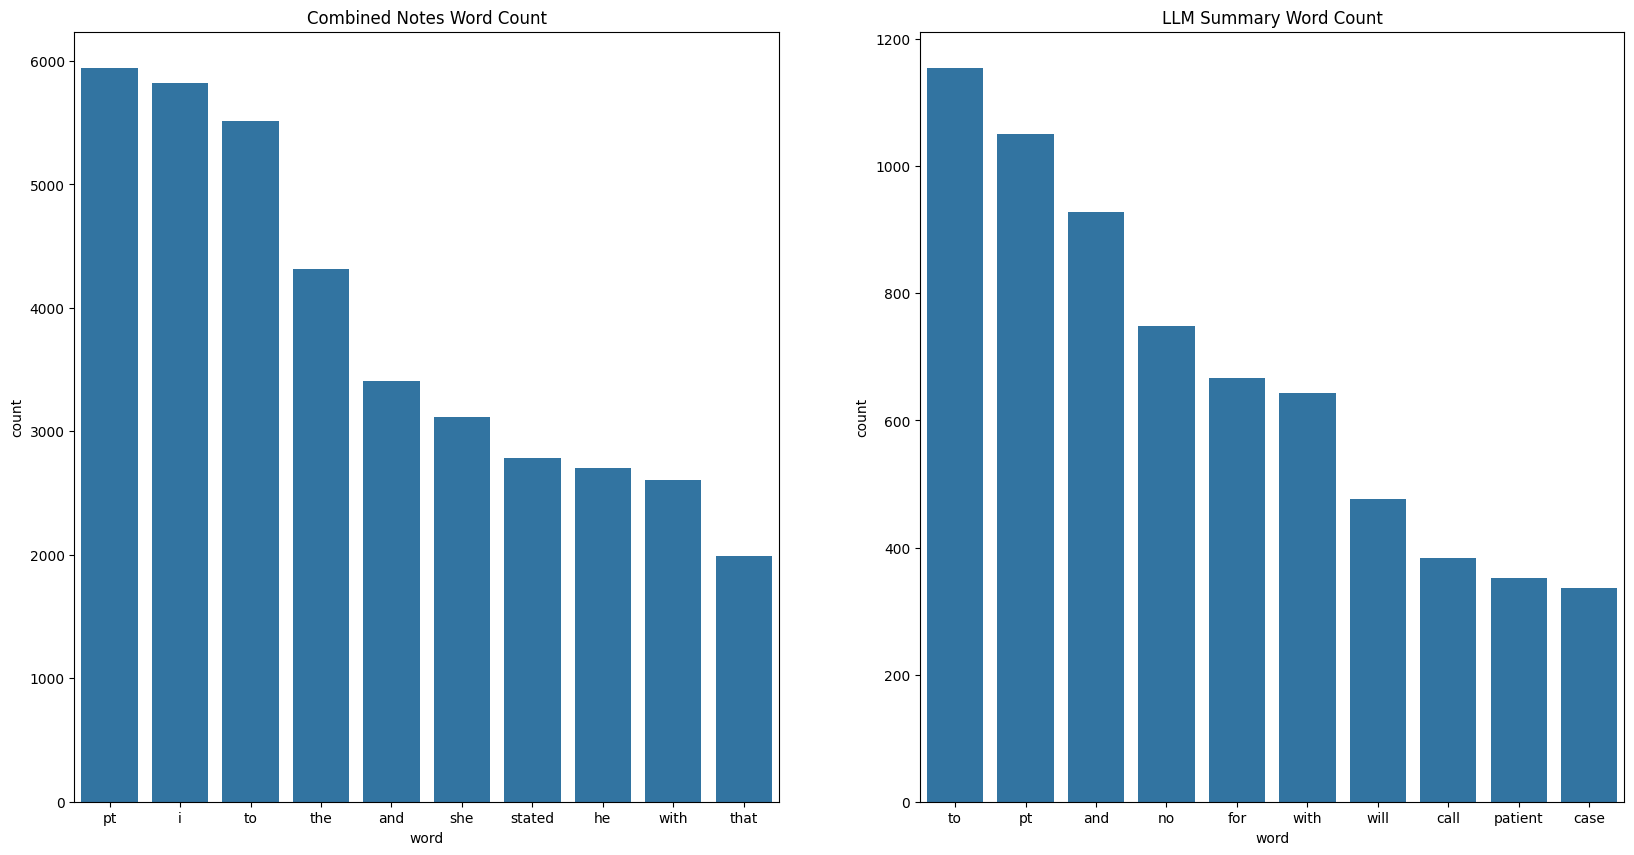

In [ ]:
# Give me bar charts with top 10  word from both tables
combined_notes_word_count_df = combined_notes_word_count_df.sort_values(by='count', ascending=False)
llm_summary_notes_word_count_df = llm_summary_notes_word_count_df.sort_values(by='count', ascending=False)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x='word', y='count', data=combined_notes_word_count_df.head(10), ax=ax[0])
sns.barplot(x='word', y='count', data=llm_summary_notes_word_count_df.head(10), ax=ax[1])
ax[0].set_title('Combined Notes Word Count')
ax[1].set_title('LLM Summary Word Count')
plt.show()

In [ ]:
# Find readmit is found or not
suhi_df['readmit_found_summary'] = suhi_df['FEW_SHORT_LLM_SUMMARY'].str.contains('readmit')
suhi_df['readmit_found_notes'] = suhi_df['COMBINED_NOTES'].str.contains('readmit')

In [ ]:
suhi_df.groupby('day_readmit')['readmit_found_notes'].value_counts()

day_readmit  readmit_found_notes
0.0          False                  1211
             True                      6
1.0          False                   232
             True                     19
2.0          False                     3
Name: count, dtype: int64

In [ ]:
suhi_df.groupby('day_readmit')['readmit_found_summary'].value_counts()

day_readmit  readmit_found_summary
0.0          False                    1214
             True                        3
1.0          False                     243
             True                        8
2.0          False                       3
Name: count, dtype: int64

In [ ]:
def preprocess(suhi_df):
    # Drop columns
    # suhi_df.drop(columns=['record_id', 'new_patient'], inplace=True, errors='ignore')
    # Remove rows with NaN in day_readmit
    suhi_df.dropna(subset=['day_readmit'], inplace=True)
    # Convert day_readmit == 2 to 0
    suhi_df.loc[suhi_df['day_readmit'] == 2, 'day_readmit'] = 0
    # Convert day_readmit to int
    suhi_df['day_readmit'] = suhi_df['day_readmit'].astype(int)
    # # Scale age
    # suhi_df['age'] = min_max_scaler.fit_transform(suhi_df[['age']])

    # # Combine note columns
    # note_cols = suhi_df.columns[suhi_df.columns.str.contains('notes_contact')]
    # if summarized ==0:
    #     # COMBINED_NOTES = suhi_df[note_cols].apply(
    #     #     lambda x: '. '.join([str(note).lower() for note in x.dropna()]),
    #     #     axis=1)
    #     # suhi_df['COMBINED_NOTES'] = COMBINED_NOTES
    #     suhi_df['COMBINED_NOTES'] = suhi_df['COMBINED_NOTES'].replace('nan', np.nan)

    # else:
    #     suhi_df['COMBINED_NOTES'] = suhi_df['FEW_SHORT_LLM_SUMMARY']
    #     suhi_df['COMBINED_NOTES'] = suhi_df['COMBINED_NOTES'].replace('nan', np.nan)

    return suhi_df
suhi_df = preprocess(suhi_df)

In [ ]:
# # include words that satisfy token_pattern=r'[a-zA-Z]{2,}'
def filter_tokens_in_notes(notes):
    pattern = re.compile(r'[a-zA-Z]{3,}')
    filtered_notes = []
    for note in notes:
        # Find all tokens that match the pattern
        filtered_tokens = pattern.findall(note)
        # Join tokens back to form the filtered note
        filtered_notes.append(' '.join(filtered_tokens))
    return filtered_notes

In [ ]:
suhi_df

,record_id,new_patient,visit_number,referral_date,day_readmit,sdoh_survey_completion,contact_attempts,engaged,age,sex_Male,...,notes_contact8,outcome_contact8,notes_contact9,outcome_contact9,notes_contact10,outcome_contact10,additional_contact_notes,anything_else,COMBINED_NOTES,FEW_SHORT_LLM_SUMMARY
2,4,1.0,1,2021-04-12,1,0.0,NaN,0,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient not available,declined,declined
3,5,1.0,1,2021-04-12,0,1.0,4.0,1,61,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh emotional support closed case,sdoh emotional support closed case
5,6,1.0,1,2021-04-12,0,0.0,4.0,0,59,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DECLINED,declined,declined
6,8,1.0,1,2021-04-12,0,1.0,NaN,0,73,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh/ declined,sdoh/ declined
7,9,1.0,1,2021-04-12,1,1.0,7.0,1,61,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,referred all her information over to the socia...,looking for housing in the same and needs acce...,"PT contacted for housing, hospitalized, CHW lo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567,2276,1.0,1,2024-01-25,1,0.0,3.0,0,29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vm is not set up. vm is not set up. mailbox is...,"Summary: VM not set up, mailbox full, unable t..."
2568,2277,1.0,1,2024-01-25,0,0.0,2.0,0,77,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,phone rang for a while and went to a busy sign...,"Summary: Phone rang with busy signal, will try..."
2570,2279,1.0,1,2024-01-25,0,0.0,3.0,0,24,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the pt two consecutive times ...,"I reached out to PT twice, no response. Provid..."
2582,2290,1.0,1,2024-01-30,0,1.0,1.0,1,82,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both phone numbers for patient is not in servi...,Patient's phone numbers not in service; spoke ...


In [ ]:
suhi_df = suhi_df[suhi_df['engaged'] == 1]

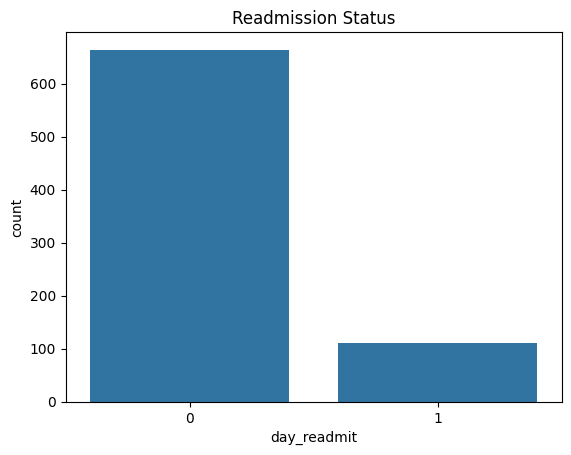

In [ ]:
sns.countplot(data=suhi_df, x='day_readmit')
plt.title('Readmission Status')
plt.show()

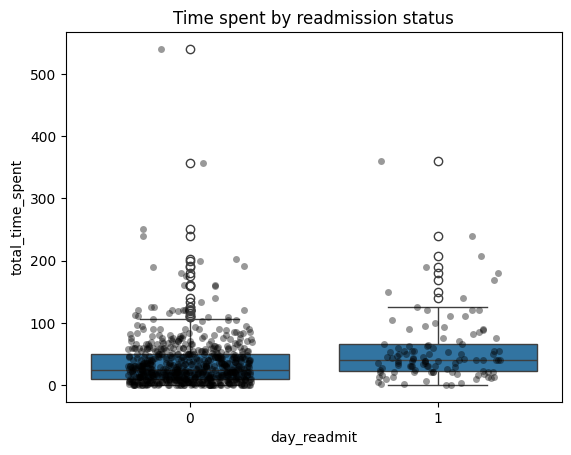

In [ ]:
sns.boxplot(x='day_readmit', y='total_time_spent', data=suhi_df)
sns.stripplot(x='day_readmit', y='total_time_spent', data=suhi_df,
              jitter=0.25, alpha=.4, color='black')
plt.title('Time spent by readmission status')
plt.show()

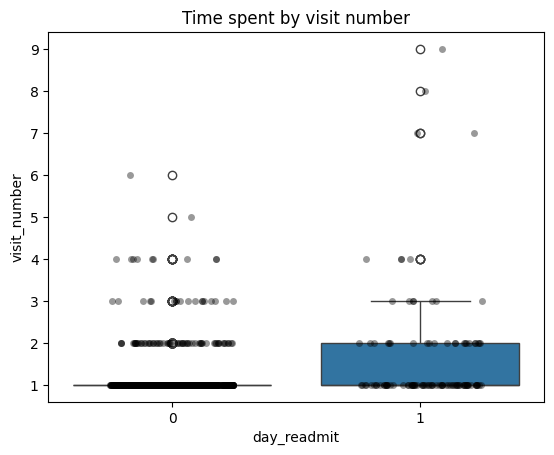

In [ ]:
sns.boxplot(x='day_readmit', y='visit_number', data=suhi_df)
sns.stripplot(x='day_readmit', y='visit_number', data=suhi_df,
              jitter=0.25, alpha=.4, color='black')
plt.title('Time spent by visit number')
plt.show()

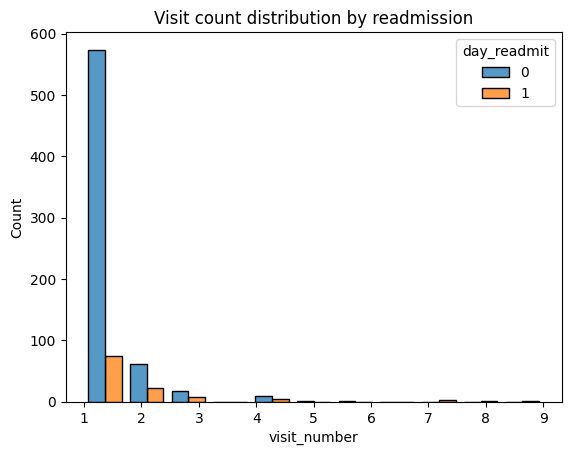

In [ ]:
sns.histplot(data=suhi_df, x='visit_number',
             hue='day_readmit', multiple='dodge', shrink=.8)
plt.title('Visit count distribution by readmission')
plt.show()

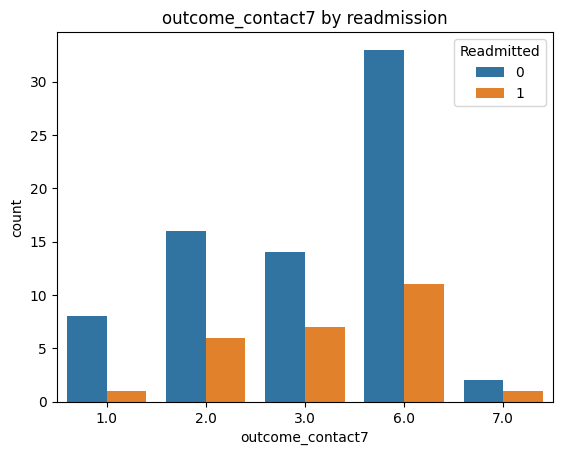

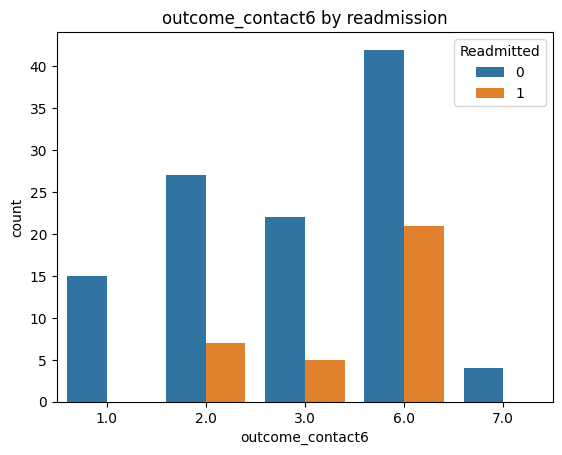

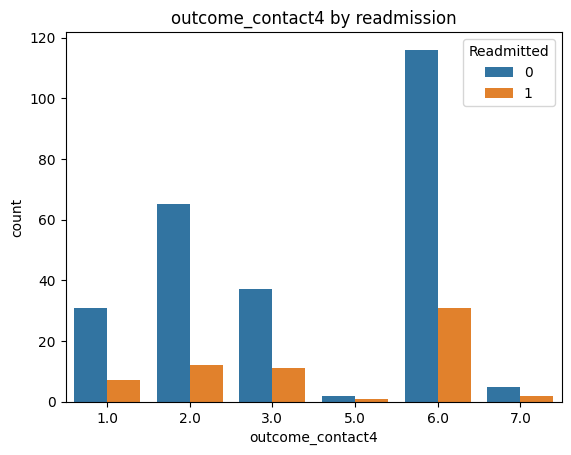

In [ ]:
tabular_columns = ['outcome_contact7', 'outcome_contact6', 'outcome_contact4']
for col in tabular_columns:
  sns.countplot(data=suhi_df, x=col,
                hue='day_readmit', dodge=True)
  plt.title(f'{col} by readmission')
  plt.legend(title='Readmitted')
  plt.show()

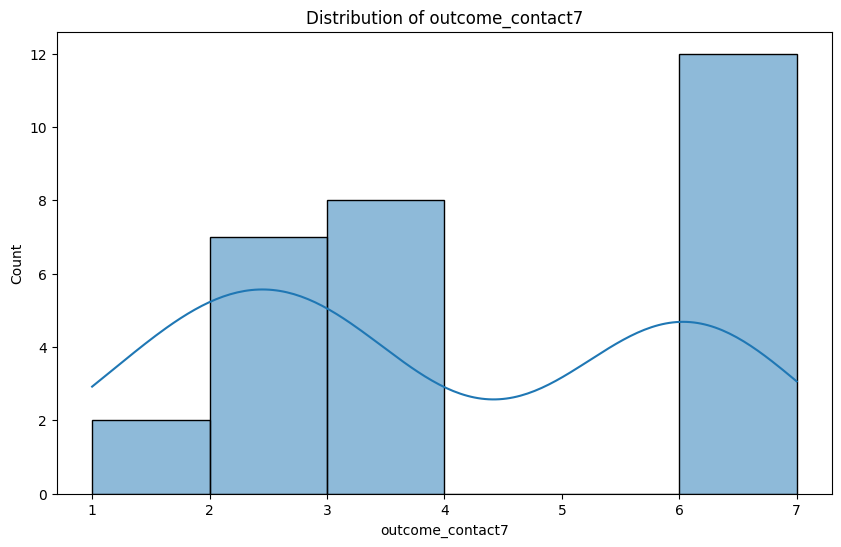

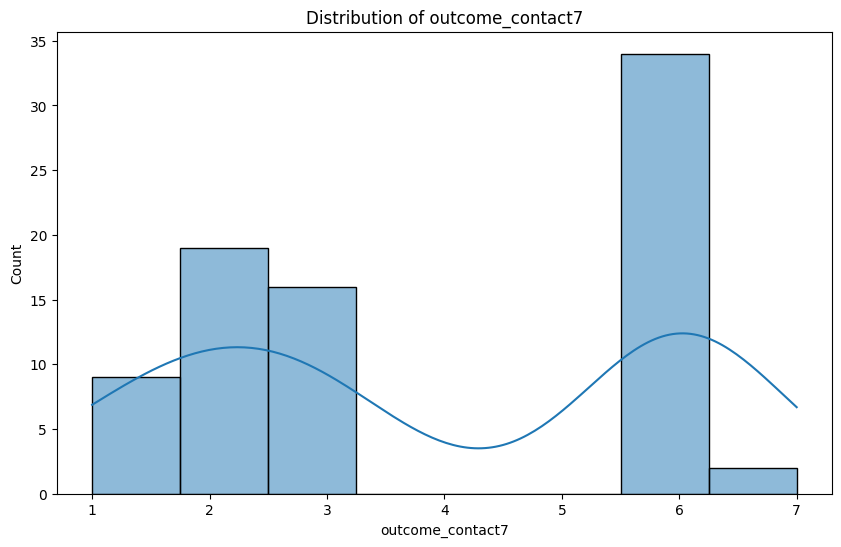

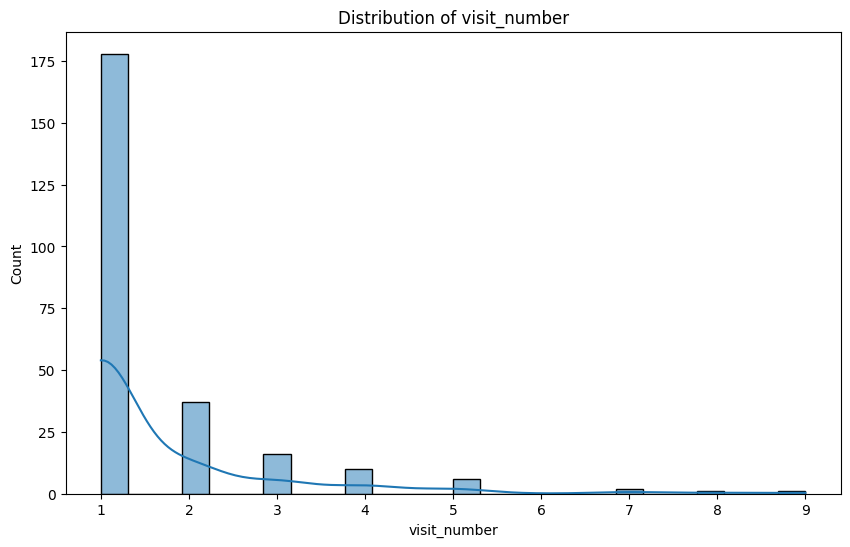

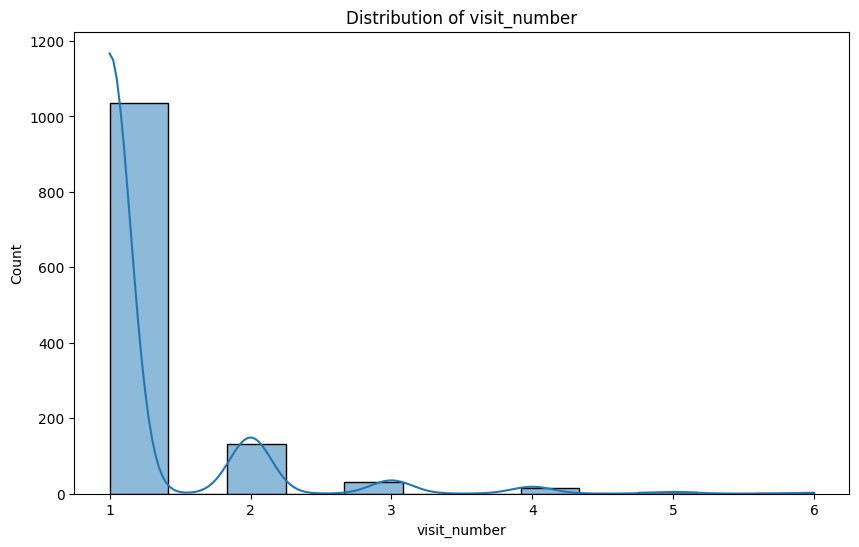

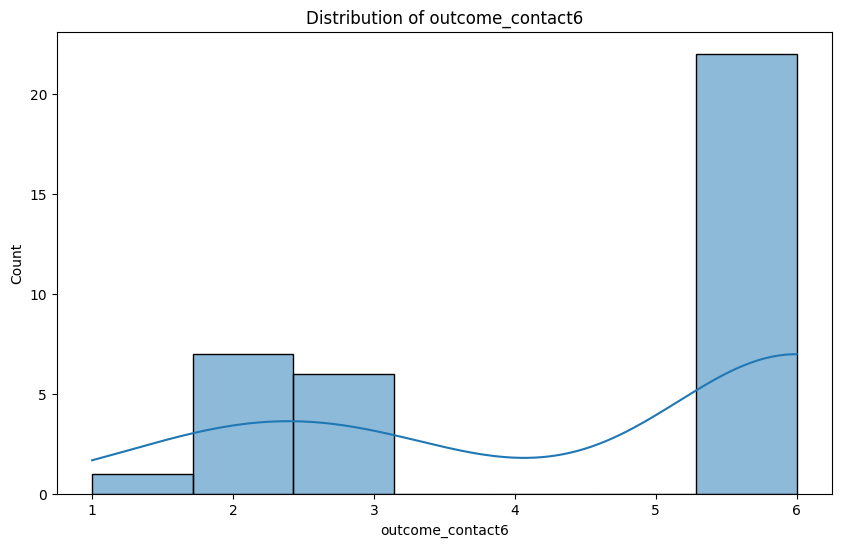

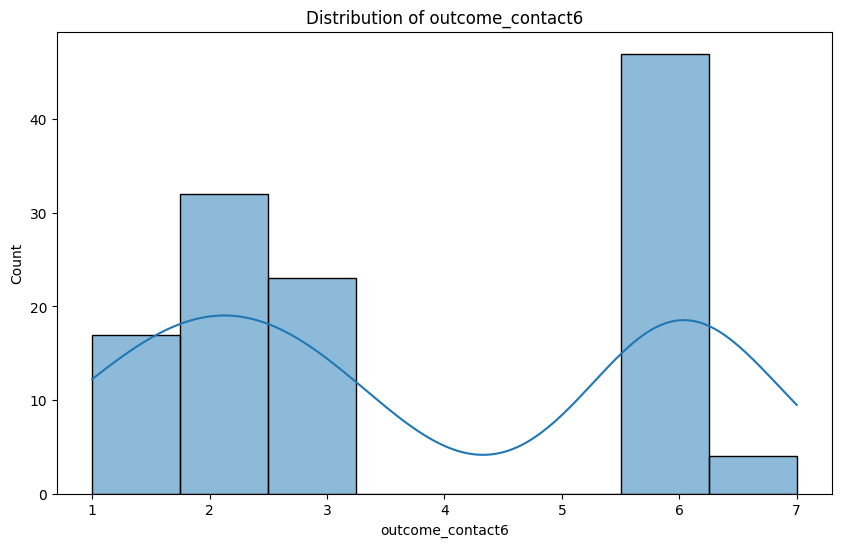

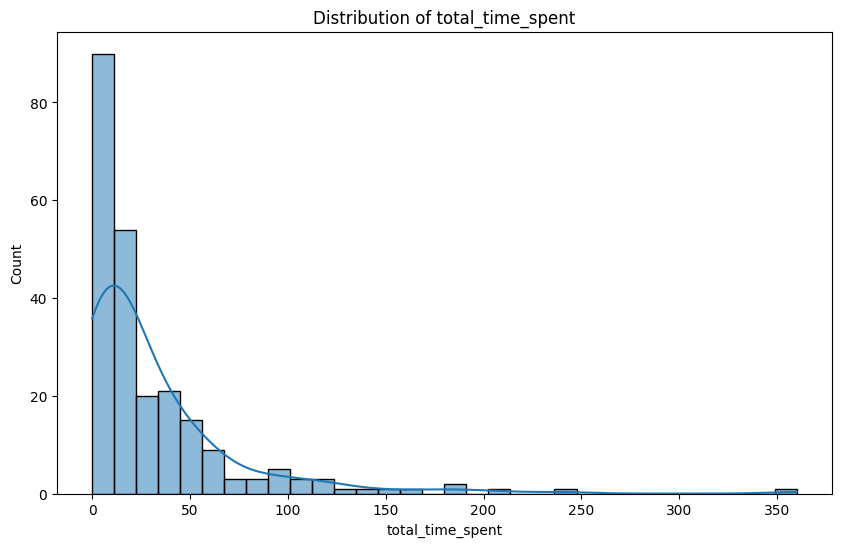

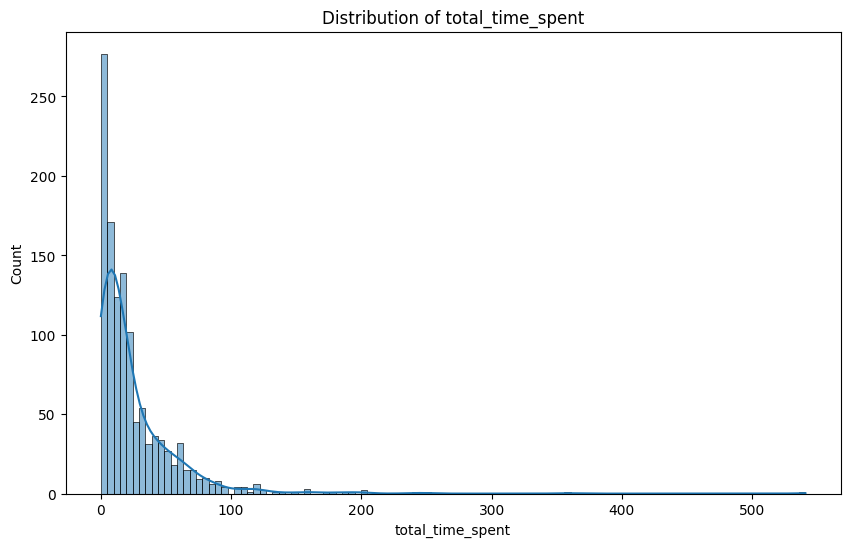

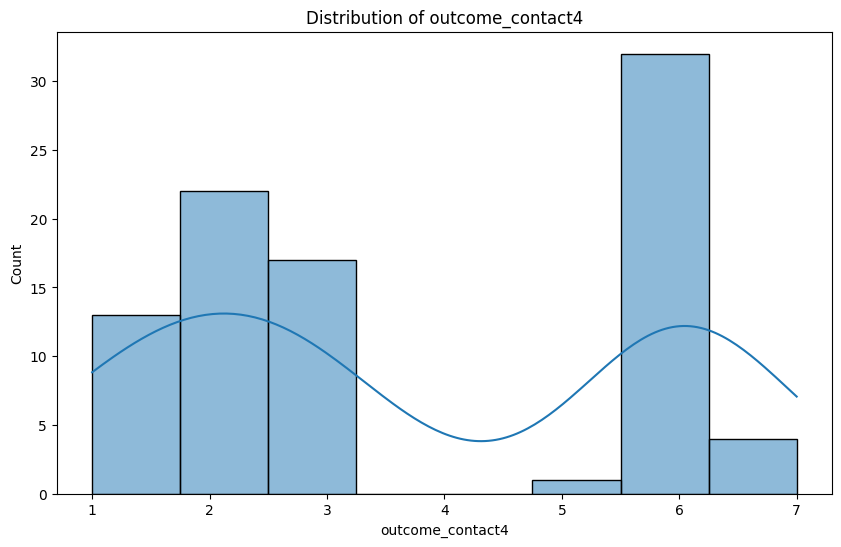

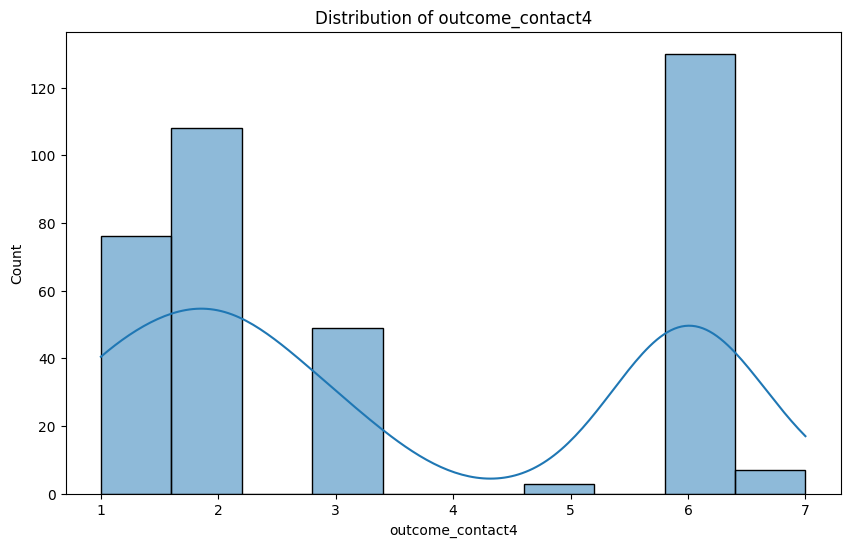

In [ ]:
# Distribution of outcome_contact7, visit_number, outcome_contact6, total_time_spent and outcome_contact4
readmitted_df = suhi_df[suhi_df['day_readmit'] == 1]
not_readmitted_df = suhi_df[suhi_df['day_readmit'] == 0]
tabular_columns = ['outcome_contact7', 'visit_number', 'outcome_contact6', 'total_time_spent', 'outcome_contact4']
for col in tabular_columns:
    for df in [readmitted_df, not_readmitted_df]:
      plt.figure(figsize=(10, 6))
      sns.histplot(df[col], kde=True)
      plt.title(f'Distribution of {col}')

In [ ]:
tf_idf_features = ['readmitted', 'admit', 'continue', 'hospital', 'appointment', 'contact', 'resource', 'msh', 'medical', 'family', 'pcp', 'good', 'lvm', 'list', 'provide']
for feature in tf_idf_features:
  suhi_df[f'{feature}_in_notes'] = suhi_df['COMBINED_NOTES'].str.contains(feature)

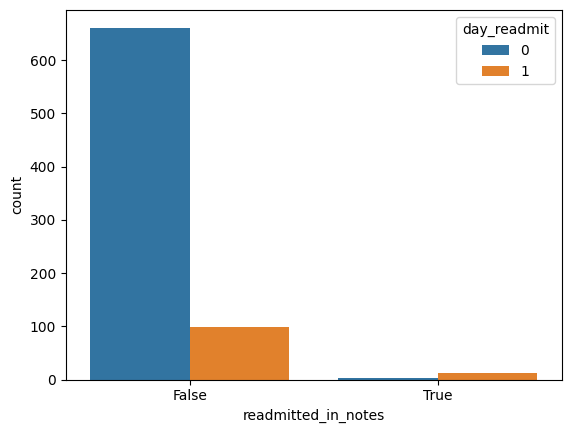

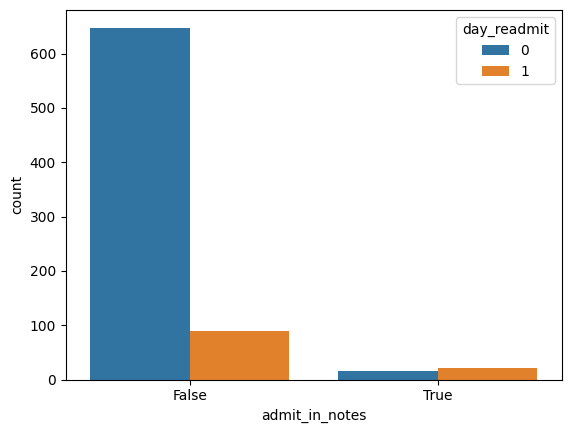

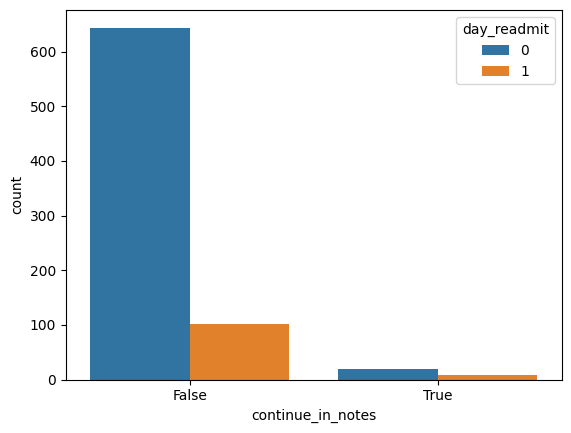

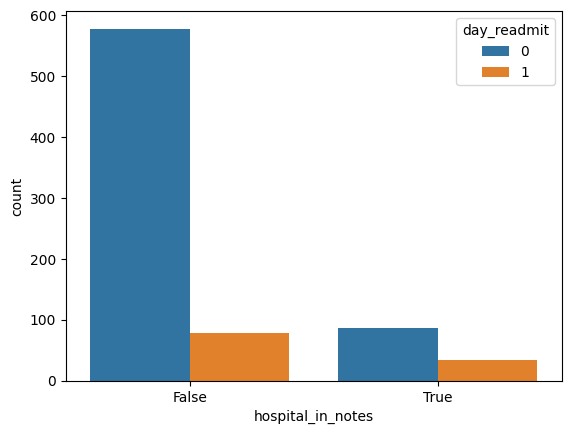

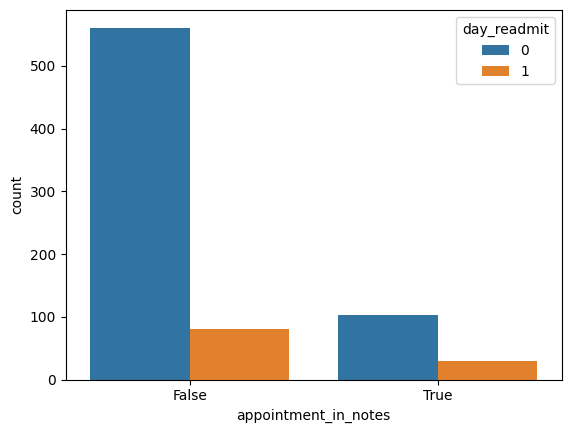

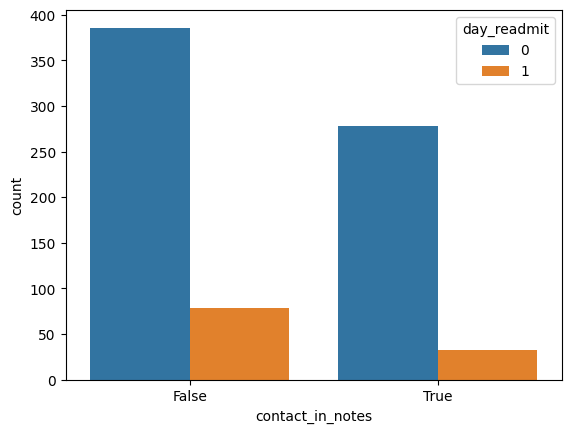

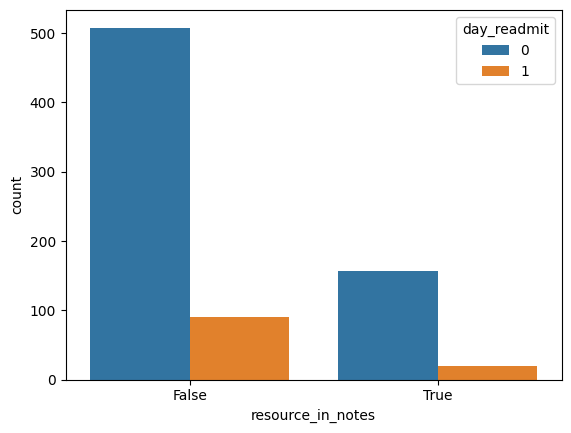

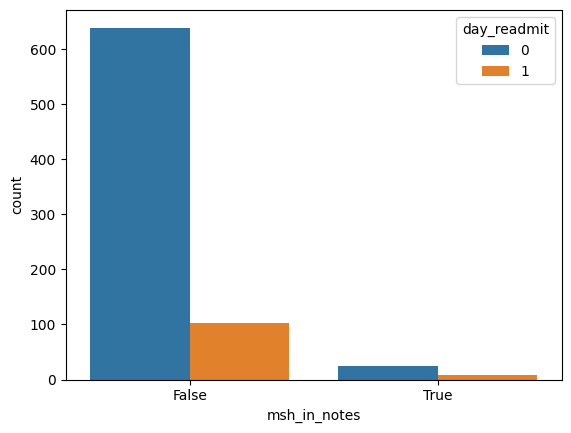

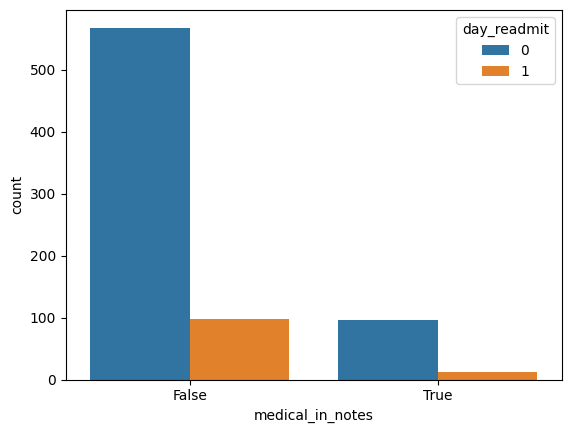

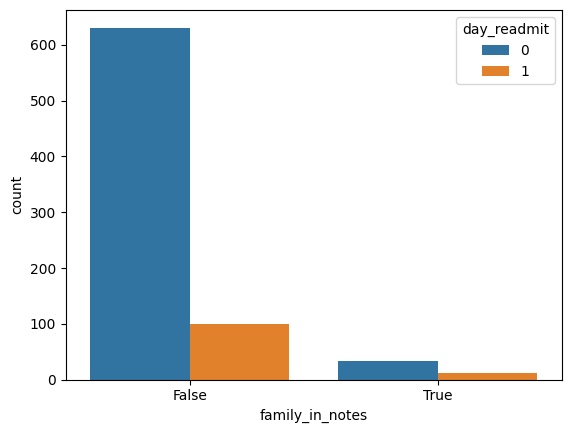

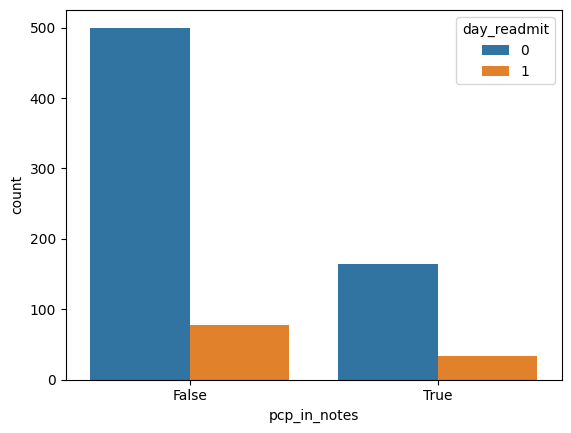

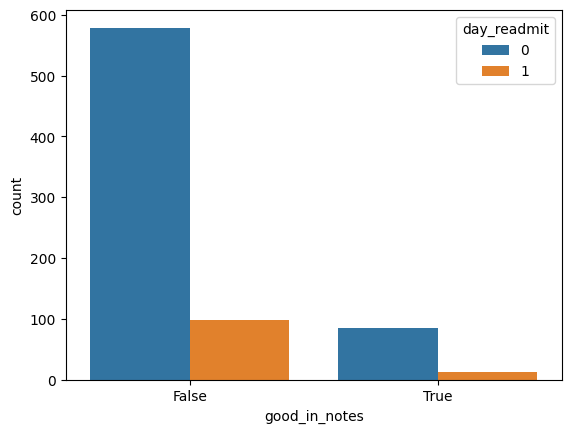

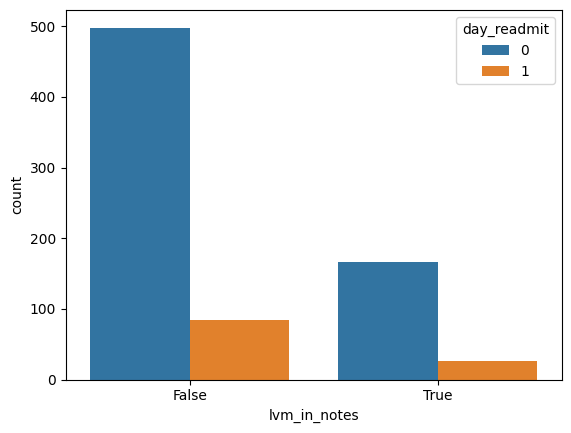

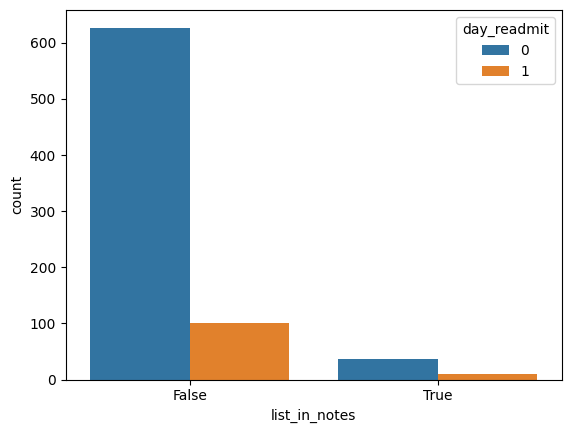

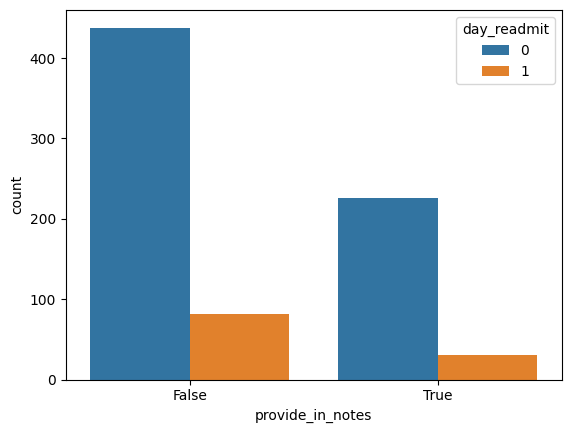

In [ ]:
# I need bar/count plot for multiple columns in tf_idf_features with legend being day_readmit
for feature in tf_idf_features:
  sns.countplot(data=suhi_df, x=f'{feature}_in_notes',
                hue='day_readmit', dodge=True)
  plt.show()

In [ ]:
for feature in tf_idf_features:
  suhi_df[f'{feature}_found_notes']

In [ ]:
suhi_df['readmitted_found_notes'] = suhi_df['COMBINED_NOTES'].str.contains('readmitted')

In [ ]:
suhi_df.groupby('day_readmit')['readmitted_found_notes'].value_counts()

day_readmit  readmitted_found_notes
0            False                     1215
             True                         5
1            False                      232
             True                        19
Name: count, dtype: int64

In [ ]:
demographic_features = [ 'day_readmit',	'age', 'sex_Male', 'Hispanic', 'AfricanAmerican', 'White',                           # 'visit_number', 'referral_date', 'hypertension'
                       'Additional_race', 'language_English', 'language_Spanish', 'language_Other']

sdoh_features = ["sdoh_PCP", "sdoh_INS", "sdoh_HOUSING", "sdoh_FOOD",
                 "sdoh_UTIL", "sdoh_TRANS", "sdoh_EMPLOY",	"sdoh_CLOTH_CHILD_PHONE",
                "sdoh_DV",	"sdoh_HIV",	"sdoh_COVID", "sdoh_DIABETES", "sdoh_ASTHMA",
                "sdoh_BILL_FU_RX_HEALTH", "sdoh_EMOTIONAL", "sdoh_SUBSTANCE_ABUSE",
                "sdoh_SAFETY", "sdoh_HOME_EQUIP", "sdoh_LEGAL", "sdoh_OTHER"]


In [ ]:
suhi_df['COMBINED_NOTES'].dropna(inplace=True)

if summarized == 0:
    if feature_subset == 1:
        # suhi_df = suhi_df[suhi_df.columns[:13]]
        suhi_df = suhi_df[demographic_features]
    elif feature_subset == 2:
        suhi_df = suhi_df[demographic_features + sdoh_features]
    else:
        suhi_df['COMBINED_NOTES'].fillna('', inplace=True)
        # suhi_df = suhi_df[demographic_features + sdoh_features +  ["COMBINED_NOTES"]]

else:
    if feature_subset == 1 or feature_subset == 2:
        pass
    #     # suhi_df = suhi_df[suhi_df.columns[:13]]
    #     suhi_df = suhi_df[demographic_features]
    # elif feature_subset == 2:
    #     suhi_df = suhi_df[demographic_features + sdoh_features]
    else:
        suhi_df['FEW_SHORT_LLM_SUMMARY'] = suhi_df['FEW_SHORT_LLM_SUMMARY'].replace('nan', '')
        # suhi_df = suhi_df[demographic_features + sdoh_features +  ["FEW_SHORT_LLM_SUMMARY"]]
        suhi_df['COMBINED_NOTES'] = suhi_df['FEW_SHORT_LLM_SUMMARY']

In [ ]:
# If we include text features and vectorize them using TF-IDF
if summarized==0:
    min_df=20
else:
    min_df=10

if feature_subset == 3 and vectorize_text == 1:
    tfidf_vectorizer = TfidfVectorizer(
        min_df= min_df,
        stop_words='english'
        # max_df=0.7,
        # stop_words='english',
        # token_pattern=r'[a-zA-Z]{2,}'
    )
    suhi_df['COMBINED_NOTES'].fillna('', inplace=True)
    suhi_df['COMBINED_NOTES'] = filter_tokens_in_notes(suhi_df['COMBINED_NOTES'])
    suhi_df['COMBINED_NOTES'] = suhi_df['COMBINED_NOTES'].apply(lemmatize_text)

    text_embeddings = tfidf_vectorizer.fit_transform(suhi_df['COMBINED_NOTES'])

print('Dropping Text and Columns')
# Drop textual/object columns (except for combining them if we do text vectorizing)
text_columns = [col for col in suhi_df.columns if suhi_df[col].dtype == 'object']
suhi_df.drop(columns=text_columns, inplace=True, errors='ignore')

# If we have vectorized text, merge them in
if feature_subset == 3 and vectorize_text == 1:
    COMBINED_NOTES_vectorized_df = pd.DataFrame(text_embeddings.toarray())
    COMBINED_NOTES_vectorized_df.columns = tfidf_vectorizer.get_feature_names_out()
    suhi_df.reset_index(drop=True, inplace=True)
    suhi_w_vectors_df = pd.concat([suhi_df, COMBINED_NOTES_vectorized_df], axis=1)

elif feature_subset == 3 and vectorize_text == 2:
    COMBINED_NOTES_vectorized_df = pd.DataFrame(text_embeddings)
    suhi_df.reset_index(drop=True, inplace=True)
    suhi_w_vectors_df = pd.concat([suhi_df, COMBINED_NOTES_vectorized_df], axis=1)
else:
    suhi_w_vectors_df = suhi_df

suhi_w_vectors_df.columns = suhi_w_vectors_df.columns.astype(str)



Dropping Text and Columns


In [ ]:
# If only tabular data is considered
suhi_w_vectors_df = suhi_df

In [ ]:
# Drop the columns with all the values are Nan
suhi_w_vectors_df.dropna(axis=1, how='all', inplace=True)
# Drop 'record_id' and 'new_patient' columns
suhi_w_vectors_df.drop(columns=['record_id', 'new_patient'], inplace=True, errors='ignore')
# Drop all the columns with dates
suhi_w_vectors_df.drop(columns=[col for col in suhi_w_vectors_df.columns if 'date' in col.lower()], inplace=True, errors='ignore')
# Drop all the columns with text
suhi_w_vectors_df.drop(columns=[col for col in suhi_w_vectors_df.columns if suhi_w_vectors_df[col].dtype == 'object'], inplace=True, errors='ignore')

In [ ]:
suhi_w_vectors_df.fillna(0, inplace=True)

In [ ]:
# only if patient engaged column has 1
suhi_w_vectors_df = suhi_w_vectors_df[suhi_w_vectors_df['engaged'] == 1]

In [ ]:
suhi_w_vectors_df

,visit_number,day_readmit,sdoh_survey_completion,contact_attempts,engaged,age,sex_Male,Hispanic,AfricanAmerican,White,...,want,wasn,way,week,wife,work,worker,wrong,year,yesterday
1,1,0,1.0,4.0,1,61,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1.0,7.0,1,61,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,1.0,3.0,1,57,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,1,1.0,2.0,1,20,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2,1,1.0,2.0,1,21,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,1,1,1.0,5.0,1,80,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1460,1,0,1.0,1.0,1,60,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1461,1,0,1.0,1.0,1,51,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1465,1,0,1.0,3.0,1,34,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

test_split_ratio = 0.2
feature_importance_scores_all_models_list = []
for seed in range(0, 50, 10):
  feature_importance_scores_list = []
  print(f"Seed: {seed}")
  X = suhi_w_vectors_df.drop('day_readmit', axis=1)
  y = suhi_w_vectors_df['day_readmit']

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_split_ratio, random_state=seed
  )

  from sklearn.model_selection import StratifiedKFold
  from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
  from xgboost import XGBClassifier
  classifiers_and_grids = {
      "RandomForestClassifier": (
          RandomForestClassifier(random_state=seed),
          {
              "n_estimators": [100],
              "max_depth": [5],
              "min_samples_split": [25]

      }
      ),
      "AdaBoostClassifier": (
          AdaBoostClassifier(random_state=seed),
          {
              "n_estimators": [100],
              "algorithm": ['SAMME'],
              "learning_rate": [0.01]
          }
      ),
      "XGBClassifier": (
          XGBClassifier(random_state=seed, eval_metric='auc', use_label_encoder=False),
          {
              "n_estimators": [100],
              "max_depth": [5],
              "learning_rate": [0.1],
          }
      )
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  from sklearn.model_selection import GridSearchCV
  sets = []
  for clf_name, (clf, param_grid) in classifiers_and_grids.items():
      grid_search = GridSearchCV(
          estimator=clf,
          param_grid=param_grid,
          scoring="roc_auc",
          cv=cv,
          refit=True,
          return_train_score=True,
          n_jobs=1,
          verbose=1
      )

      grid_search.fit(X_train, y_train)
      best_model = grid_search.best_estimator_
      print(f"{clf_name} Best Parameters: {best_model.get_params()}")
      # training performance
      train_score = best_model.score(X_train, y_train)
      print(f"{clf_name} Train Score: {train_score}")
      # model performance
      y_pred = best_model.predict(X_test)
      y_pred_proba = best_model.predict_proba(X_test)[:, 1]
      roc_auc_score = best_model.score(X_test, y_test)
      print(f"{clf_name} ROC AUC Score: {roc_auc_score}")
      best_params = best_model.get_params()

      # model roc-auc
      from sklearn.metrics import roc_curve, auc
      fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
      roc_auc = auc(fpr, tpr)
      print(f"{clf_name} ROC AUC: {roc_auc}")

      feature_importances = best_model.feature_importances_
      sorted_idx = np.argsort(feature_importances)[::-1]
      important_features = [X_train.columns[i] for i in sorted_idx]

      # Get features and it's respective importance scores in the form of a dictionary
      feature_importance_scores = dict(zip(X_train.columns, feature_importances))
      feature_importance_scores_list.append(feature_importance_scores)
  feature_importance_scores_all_models_list.append(feature_importance_scores_list)
      # Get the top 25% of the features
      # top_25_percent = int(0.25 * len(feature_importances))
      # top_25_features = important_features[:top_25_percent]

      # sets.append(set(top_25_features))

Seed: 0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomForestClassifier Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
RandomForestClassifier Train Score: 0.85
RandomForestClassifier ROC AUC Score: 0.9032258064516129
RandomForestClassifier ROC AUC: 0.6590476190476191
Fitting 5 folds for each of 1 candidates, totalling 5 fits
AdaBoostClassifier Best Parameters: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 0}
AdaBoostClassifier Train Score: 0.8451612903225807
AdaBoostClassifier ROC AUC Score: 0.9032258064516129
AdaBoostClassifier ROC AUC: 0

In [ ]:
len(feature_importance_scores_all_models_list)

5

In [ ]:
transposed = [list(row) for row in zip(*feature_importance_scores_all_models_list)]

In [ ]:
len(transposed)

3

In [ ]:
sets = []
for feature_importance_scores_list in transposed:
    # Convert to DataFrame
    feature_importance_scores_df = pd.DataFrame(feature_importance_scores_list)
    print(feature_importance_scores_df)
    # Compute mean and std deviation
    summary_feature_importance_scores_df = pd.DataFrame({
        'feature': feature_importance_scores_df.columns,
        'mean_importance': feature_importance_scores_df.mean(),
        'std_importance': feature_importance_scores_df.std()
    }).reset_index(drop=True)

    # Sort by mean_importance
    combined_notes_summary_df = summary_feature_importance_scores_df.sort_values(by='mean_importance', ascending=False)

    top_25_percent = int(0.25 * len(combined_notes_summary_df))
    top_25_features = combined_notes_summary_df['feature'][:top_25_percent]

    sets.append(set(top_25_features))

   visit_number  sdoh_survey_completion  contact_attempts  engaged       age  \
0      0.029932                     0.0          0.002790      0.0  0.009636   
1      0.027157                     0.0          0.002720      0.0  0.006711   
2      0.017589                     0.0          0.013237      0.0  0.016737   
3      0.022286                     0.0          0.015245      0.0  0.020319   
4      0.012552                     0.0          0.011199      0.0  0.012315   

   sex_Male  Hispanic  AfricanAmerican     White  Additional_race  ...  \
0  0.000000       0.0         0.000082  0.000000         0.000019  ...   
1  0.000485       0.0         0.000000  0.000000         0.000000  ...   
2  0.000000       0.0         0.001754  0.000000         0.000748  ...   
3  0.000532       0.0         0.000989  0.000621         0.003201  ...   
4  0.000000       0.0         0.001120  0.000000         0.000000  ...   

       want      wasn       way      week      wife      work    worker  \

In [ ]:
len(sets)

3

In [ ]:
# Iterate through the summary_df's feature columns and add ** infront of the values in the tf list
updated_features = []
for feature in combined_notes_summary_df['feature']:
  if feature in tfidf_vectorizer.get_feature_names_out():
    updated_features.append(f"*{feature}")
  else:
    updated_features.append(feature)
print(updated_features)
combined_notes_summary_df['feature'] = updated_features

['*readmitted', '*admit', '*continue', 'outcome_contact7', '*hospital', 'visit_number', '*appointment', 'outcome_contact6', '*contact', '*resource', '*msh', '*medical', 'total_time_spent', 'outcome_contact4', '*family', '*pcp', '*good', '*lvm', '*list', '*provide', 'sdoh_FOOD', '*request', '*send', '*schedule', '*insurance', 'contact_attempts', '*home', '*wait', '*food', '*leave', '*close', '*utility', '*service', '*spoke', '*appt', '*check', 'outcome_contact1', '*day', '*patient', '*time', '*reach', 'age', '*regard', 'AfricanAmerican', '*transportation', '*didn', '*pantry', 'outcome_contact2', '*message', 'outcome_contact5', '*week', '*number', '*unable', '*visit', 'sdoh_DIABETES', '*assist', '*need', '*discharge', '*stop', '*use', '*right', '*phone', '*doesn', '*tomorrow', '*info', '*speak', '*hch', '*confirm', '*soon', '*able', '*agree', '*nowpow', '*start', '*form', 'outcome_contact9', '*know', '*wasn', '*http', '*daughter', '*upcoming', '*follow', '*son', '*future', '*pain', '*com

In [ ]:
combined_notes_summary_df.to_csv('XGBoostFeatureImportancesTabularActualNotes.csv', index=False)

In [ ]:
# Filter top 20 rows of a df
summary_df = combined_notes_summary_df.head(20)

In [ ]:
# Iterate through the summary_df's feature columns and add ** infront of the values in the tf list
updated_features = []
for feature in summary_df['feature']:
  if feature in tfidf_vectorizer.get_feature_names_out():
    updated_features.append(f"*{feature}")
  else:
    updated_features.append(feature)
print(updated_features)

['*readmitted', '*admit', '*continue', 'outcome_contact7', '*hospital', 'visit_number', '*appointment', 'outcome_contact6', '*contact', '*resource', '*msh', '*medical', 'total_time_spent', 'outcome_contact4', '*family', '*pcp', '*good', '*lvm', '*list', '*provide']


In [ ]:
summary_df['feature'] = updated_features

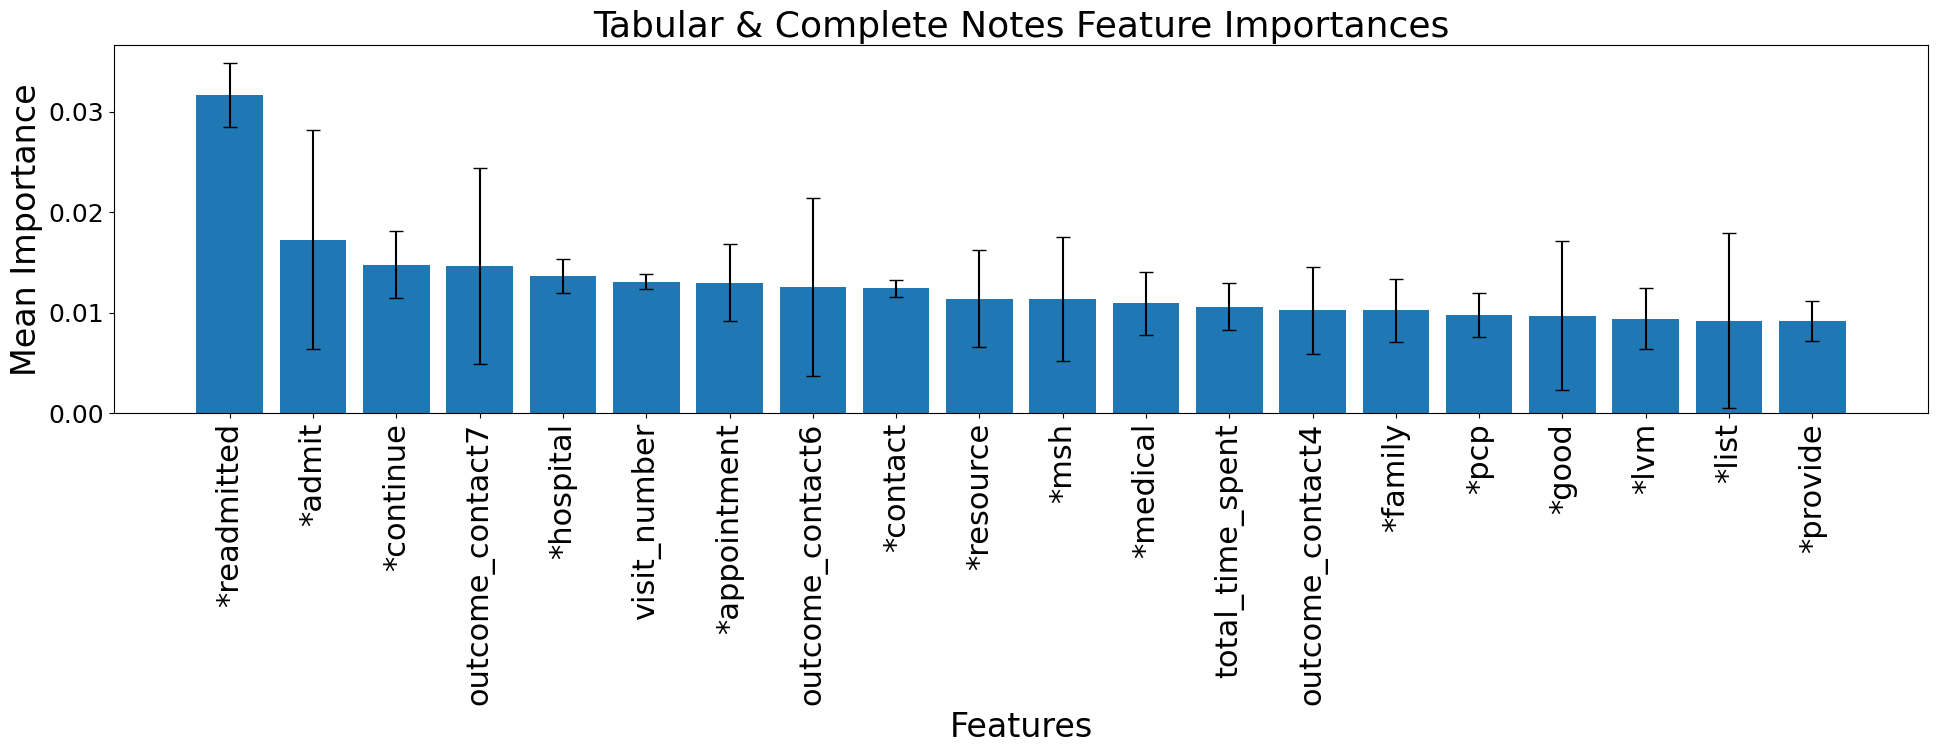

In [ ]:
# Make a bar graph with mean_importance column as bar length and std_importance as the line on the bar for the first 20 features
plt.figure(figsize=(20, 8))
plt.bar(summary_df['feature'], summary_df['mean_importance'], yerr=summary_df['std_importance'], capsize=5)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Feature Importance Summary')
# Increase font size as per the type of the text
plt.xticks(fontsize=22)
plt.yticks(fontsize=18)
plt.xlabel('Features', fontsize=24)
plt.ylabel('Mean Importance', fontsize=24)
plt.title('Tabular & Complete Notes Feature Importances', fontsize=26)
# saved figure should inlcude vertical ticks on x -axis
plt.tight_layout()
plt.savefig('xgb_feature_importances_with_actualnotes.pdf', bbox_inches='tight') # _with_summarized_notes
plt.show()

In [ ]:
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
important_features = [X_train.columns[i] for i in sorted_idx]

In [ ]:
X_train.columns[0]

'visit_number'

In [ ]:
X_train.columns[283]

'readmitted'

In [ ]:
feature_importances

array([0.01411248, 0.        , 0.00736988, 0.        , 0.00968321,
       0.00251764, 0.        , 0.        , 0.        , 0.00939911,
       0.        , 0.        , 0.        , 0.00660809, 0.00778673,
       0.00796175, 0.        , 0.00833622, 0.        , 0.00597719,
       0.        , 0.        , 0.01665334, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0065417 , 0.00652691, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0133241 ,
       0.        , 0.        , 0.00557889, 0.00326394, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00340255, 0.        ,
       0.        , 0.        , 0.02049137, 0.        , 0.        ,
       0.01098403, 0.00350729, 0.00330014, 0.00567875, 0.00337671,
       0.        , 0.01250577, 0.        , 0.        , 0.        ,
       0.0100979 , 0.        , 0.        , 0.        , 0.01148

In [ ]:
sorted_idx

array([283, 362, 131,  57,  83,  22, 254, 137, 118, 297, 122, 156, 231,
         0, 351,  39, 184, 121, 224,  66, 296, 267, 264,  74, 277,  60,
       335, 322, 182,  70, 324, 357,  98,   4, 274,   9, 263, 305,  85,
       301,  17, 111, 323, 114, 197, 317,  15,  14, 246,   2, 249, 311,
       239, 136, 119, 248,  13,  30,  31, 343,  78, 202, 149, 169, 307,
       140, 215, 304, 346,  89, 347, 329,  19, 310, 279, 359, 211, 350,
        63,  42, 290, 125, 132, 262, 208, 289, 345, 325, 356, 162, 319,
       102, 199, 213, 285, 255, 367, 294,  90,  88, 365, 130, 282, 312,
       157, 183,  61, 269, 361,  53, 186,  64,  62, 209,  43, 198, 243,
       344, 226, 189, 203, 358, 364, 171, 240,   5, 252, 337, 116, 250,
       176, 163, 314, 299, 355, 354, 353, 352,  23,  21,  20,   3, 372,
         1,  34, 370,  41, 253, 366, 368,  11,  10,   8,   7, 238, 237,
       236, 235, 234, 233, 232, 230, 229, 228, 275, 273, 272, 271, 270,
       268, 266, 265, 261, 260, 227, 225, 371, 373,  40,  38,  3

In [ ]:
important_features

['readmitted',
 'wait',
 'day',
 'home_equip_referrals_used',
 'appointment',
 'sdoh_FOOD',
 'nowpow',
 'discharge',
 'confirm',
 'resource',
 'continue',
 'family',
 'medical',
 'visit_number',
 'unavailable',
 'total_time_spent',
 'hospital',
 'contact',
 'lvm',
 'outcome_contact7',
 'request',
 'pcp',
 'patient',
 'admit',
 'provide',
 'outcome_contact1',
 'talk',
 'speak',
 'home',
 'able',
 'start',
 'utility',
 'brother',
 'age',
 'problem',
 'Additional_race',
 'pantry',
 'schedule',
 'appt',
 'right',
 'uninsured',
 'close',
 'spoke',
 'com',
 'info',
 'snap',
 'private_insurance',
 'public_insurance',
 'msh',
 'contact_attempts',
 'new',
 'service',
 'mom',
 'didn',
 'connect',
 'need',
 'hypertension',
 'sdoh_DIABETES',
 'sdoh_ASTHMA',
 'time',
 'agree',
 'insurance',
 'encourage',
 'future',
 'sdoh',
 'doesn',
 'like',
 'say',
 'transportation',
 'assist',
 'try',
 'stop',
 'sdoh_PCP',
 'send',
 'pt',
 'visit',
 'leave',
 'unable',
 'outcome_contact4',
 'housing_referrals_us

In [ ]:
# Visualize top 10 features from the XGBoost model along with their explained variance
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
important_features = [X_train.columns[i] for i in sorted_idx]

In [ ]:
important_features

['readmitted',
 'wait',
 'day',
 'home_equip_referrals_used',
 'appointment',
 'sdoh_FOOD',
 'nowpow',
 'discharge',
 'confirm',
 'resource',
 'continue',
 'family',
 'medical',
 'visit_number',
 'unavailable',
 'total_time_spent',
 'hospital',
 'contact',
 'lvm',
 'outcome_contact7',
 'request',
 'pcp',
 'patient',
 'admit',
 'provide',
 'outcome_contact1',
 'talk',
 'speak',
 'home',
 'able',
 'start',
 'utility',
 'brother',
 'age',
 'problem',
 'Additional_race',
 'pantry',
 'schedule',
 'appt',
 'right',
 'uninsured',
 'close',
 'spoke',
 'com',
 'info',
 'snap',
 'private_insurance',
 'public_insurance',
 'msh',
 'contact_attempts',
 'new',
 'service',
 'mom',
 'didn',
 'connect',
 'need',
 'hypertension',
 'sdoh_DIABETES',
 'sdoh_ASTHMA',
 'time',
 'agree',
 'insurance',
 'encourage',
 'future',
 'sdoh',
 'doesn',
 'like',
 'say',
 'transportation',
 'assist',
 'try',
 'stop',
 'sdoh_PCP',
 'send',
 'pt',
 'visit',
 'leave',
 'unable',
 'outcome_contact4',
 'housing_referrals_us

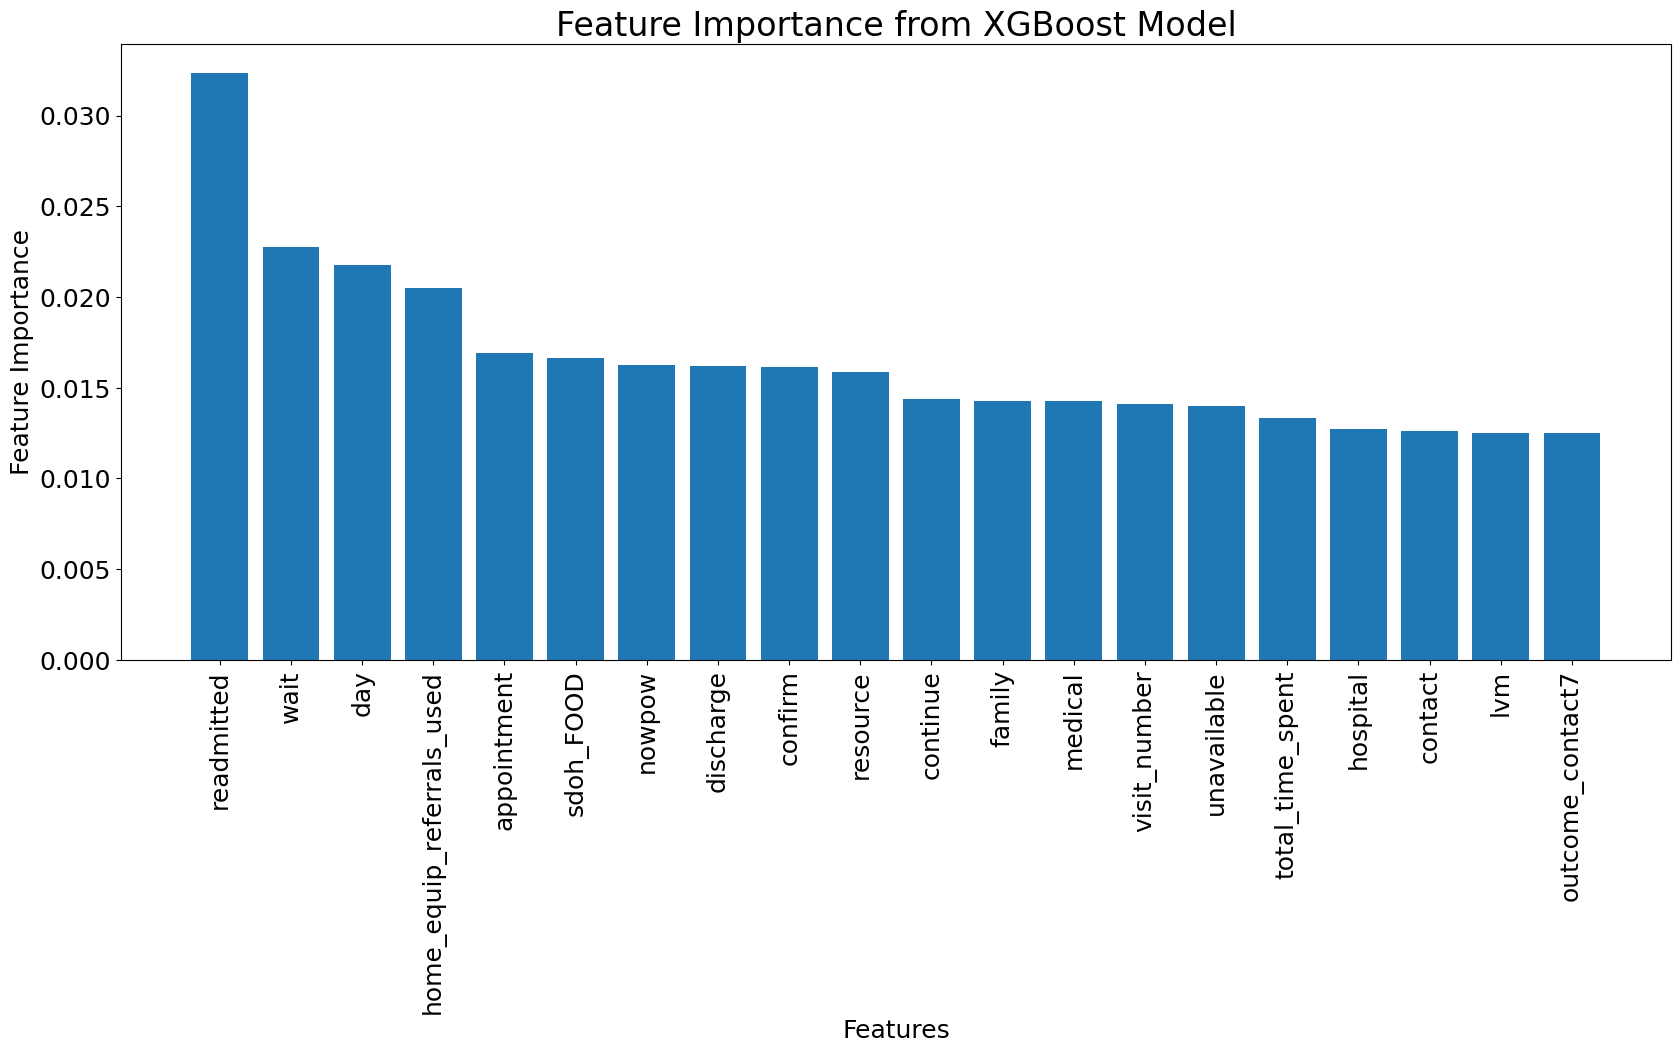

In [ ]:
# plot important features on x-axis and respective feature importances on y-axis
plt.figure(figsize=(20, 8))
plt.bar(range(len(feature_importances[:20])), feature_importances[sorted_idx][:20])
plt.xticks(range(len(feature_importances[:20])), important_features[:20], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')
# increase the font size of title, ticks and axis labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Feature Importance', fontsize=18)
plt.title('Feature Importance from XGBoost Model', fontsize=24)
plt.show()

In [ ]:
X_train.columns

Index(['visit_number', 'sdoh_survey_completion', 'contact_attempts', 'engaged',
       'age', 'sex_Male', 'Hispanic', 'AfricanAmerican', 'White',
       'Additional_race',
       ...
       'want', 'wasn', 'way', 'week', 'wife', 'work', 'worker', 'wrong',
       'year', 'yesterday'],
      dtype='object', length=374)

In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# set1 = set(['age', 'gender', 'income', 'comorbidity'])
# set2 = set(['age', 'income', 'comorbidity', 'insurance', 'zipcode'])
# set3 = set(['age', 'zipcode', 'language', 'comorbidity'])

# venn3([set1, set2, set3], ('Model A', 'Model B', 'Model C'))
venn3(sets, ('1', '2', '3', '4', '5'))
# title
plt.title('Feature Importance Agreements Venn Diagram')
plt.savefig('feature_importance_agreements_all_features.pdf')
plt.show()

TypeError: bad operand type for abs(): 'set'

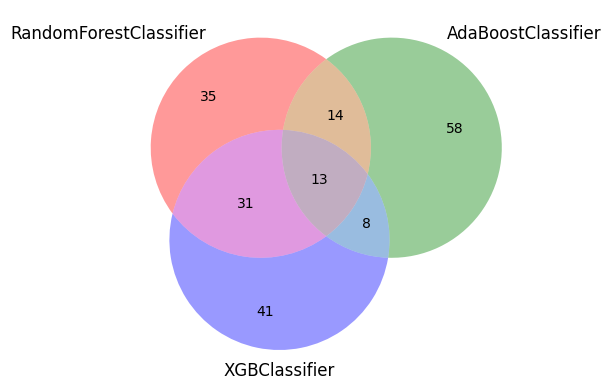

In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# set1 = set(['age', 'gender', 'income', 'comorbidity'])
# set2 = set(['age', 'income', 'comorbidity', 'insurance', 'zipcode'])
# set3 = set(['age', 'zipcode', 'language', 'comorbidity'])

# venn3([set1, set2, set3], ('Model A', 'Model B', 'Model C'))
venn3(sets, ('RandomForestClassifier', 'AdaBoostClassifier', 'XGBClassifier'))
# title
plt.title('Feature Importance Agreements Venn Diagram')
plt.savefig('feature_importance_agreements_all_features.pdf')
plt.show()

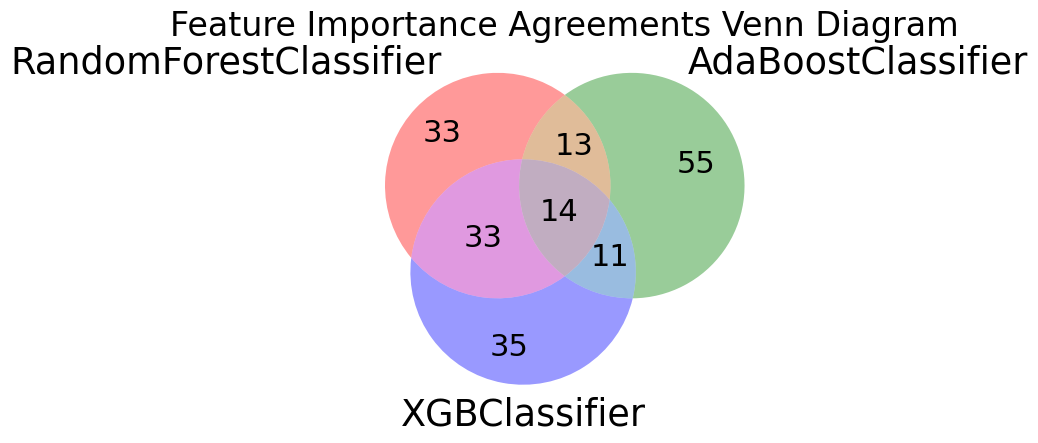

In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# set1 = set(['age', 'gender', 'income', 'comorbidity'])
# set2 = set(['age', 'income', 'comorbidity', 'insurance', 'zipcode'])
# set3 = set(['age', 'zipcode', 'language', 'comorbidity'])

# venn3([set1, set2, set3], ('Model A', 'Model B', 'Model C'))
venn3(sets, ('RandomForestClassifier', 'AdaBoostClassifier', 'XGBClassifier'))
# title
plt.title('Feature Importance Agreements Venn Diagram')
plt.savefig('feature_importance_agreements_top25_percentfeatures.pdf')
# reduce font sizes of venns

plt.show()

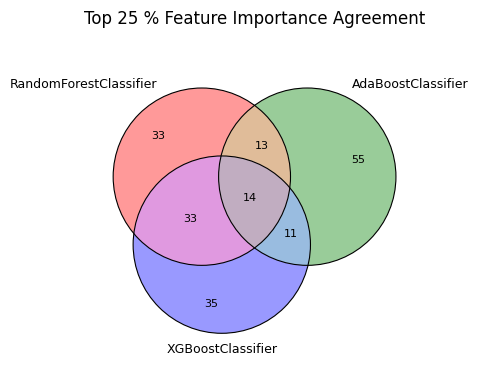

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# --- data & figure ---
fig, ax = plt.subplots(figsize=(5, 5))           # shrink the canvas
v = venn3(sets, set_labels=('RandomForestClassifier',
                            'AdaBoostClassifier',
                            'XGBoostClassifier'),
          ax=ax)

# --- font sizes --------------------------------------------------------
title_fs   = 12      # title font size
label_fs   = 9       # size of the three set names
region_fs  = 8       # numbers in the intersections

# title
ax.set_title('Top 25 % Feature Importance Agreement', fontsize=title_fs, pad=30)

# “RandomForestClassifier”, “AdaBoostClassifier”, “XGBClassifier”
plt.setp(v.set_labels,   fontsize=label_fs)

# counts inside every region (‘100’, ‘110’, etc.)
for subset in ('100', '010', '001', '110', '101', '011', '111'):
    text = v.get_label_by_id(subset)
    if text:                      # some regions may be empty
        text.set_fontsize(region_fs)

# optional: thinner circle outlines
venn3_circles(sets, ax=ax, linewidth=0.8)

# tidy spacing and save
plt.tight_layout()
plt.savefig('feature_importance_agreements_top25_percentfeatures.pdf', dpi=300)
plt.show()


In [ ]:
common_terms = []
for elem in sets[0]:
    if elem in sets[1] and elem in sets[2]:
        common_terms.append(elem)

In [ ]:
len(common_terms)

14

In [ ]:
common_terms

['readmitted',
 'contact',
 'leave',
 'pcp',
 'visit_number',
 'total_time_spent',
 'msh',
 'list',
 'need',
 'hospital',
 'pain',
 'outcome_contact4',
 'outcome_contact6',
 'patient']

In [ ]:
sets[2]

{'Additional_race',
 'AfricanAmerican',
 'White',
 'access',
 'additional',
 'admit',
 'age',
 'answer',
 'application',
 'ask',
 'assist',
 'assistance',
 'assisted',
 'asthma',
 'attempt',
 'called',
 'case',
 'catholic',
 'chw',
 'close',
 'complete',
 'confirm',
 'contact',
 'education',
 'emergency',
 'feel',
 'follow',
 'future',
 'hch',
 'home',
 'hospital',
 'info',
 'inpatient',
 'issue',
 'language_English',
 'leave',
 'mom',
 'need',
 'number',
 'patient',
 'pcp',
 'phone',
 'reach',
 'readmitted',
 'reschedule',
 'resource',
 'response',
 'schedule',
 'sdoh_CLOTH_CHILD_PHONE',
 'sdoh_DIABETES',
 'sdoh_HOME_EQUIP',
 'sdoh_LEGAL',
 'sdoh_OTHER',
 'sdoh_PCP',
 'sdoh_SAFETY',
 'sex_Male',
 'sister',
 'speak',
 'summary',
 'support',
 'transportation',
 'twice',
 'unable',
 'unavailable',
 'upcoming',
 'update',
 'use',
 'utility',
 'vaccinate',
 'vaccination',
 'vaccine',
 'week'}